In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy import stats
import random
from scipy import optimize
from scipy import spatial

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
eda_df = pd.read_csv('eda_stage.csv')

In [3]:
eda_df.shape

(534781, 24)

In [4]:
eda_df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,...,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,...,90,20,86,TMA,268,10,No,forumng,19,1
1,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,...,90,20,86,TMA,268,10,No,forumng,19,1
2,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,...,90,20,86,TMA,268,10,No,homepage,19,10
3,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,...,90,20,86,TMA,268,10,No,subpage,19,2
4,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,...,90,20,86,TMA,268,10,No,subpage,19,1


In [5]:
eda_df['disability'].replace('No', 0, inplace = True)
eda_df['disability'].replace('Yes', 1, inplace = True)

eda_df['is_banked'].replace('No', 0, inplace = True)
eda_df['is_banked'].replace('Yes', 1, inplace = True)

C:\Users\jacob\AppData\Local\Temp\ipykernel_34212\1682318704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_df['disability'].replace('No', 0, inplace = True)
C:\Users\jacob\AppData\Local\Temp\ipykernel_34212\1682318704.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [6]:
col_order = [x for x in eda_df.columns]

for c in col_order:
    print(c)
    print(eda_df[c].value_counts())
    print(eda_df[c].dtypes)
    print(eda_df[c].info)
    print()

id_student
id_student
2646317    1225
604879      648
556251      560
402449      550
308363      541
           ... 
683764        1
677167        1
226955        1
74165         1
635779        1
Name: count, Length: 16193, dtype: int64
int64
<bound method Series.info of 0         2412002
1         2412002
2         2412002
3         2412002
4         2412002
           ...   
534776     650630
534777     650630
534778     650630
534779     650630
534780     635779
Name: id_student, Length: 534781, dtype: int64>

gender
gender
Male      335073
Female    199708
Name: count, dtype: int64
object
<bound method Series.info of 0           Male
1           Male
2           Male
3           Male
4           Male
           ...  
534776      Male
534777      Male
534778      Male
534779      Male
534780    Female
Name: gender, Length: 534781, dtype: object>

disability
disability
0    493237
1     41544
Name: count, dtype: int64
int64
<bound method Series.info of 0         0
1         0
2    

In [7]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

In [15]:
var_df = eda_df[['gender', 'disability', 'age_band', 'region', 'imd_band', 'highest_education', 
                 'date_registration', 'num_of_prev_attempts', 'final_result', 'studied_credits',
                 'date_submitted', 'score', 'assessment_type', 'module_presentation_length',
                 'weight', 'activity_type', 'date', 'sum_click']]
quant_df = var_df[['date_registration', 'num_of_prev_attempts', 'studied_credits', 'date_submitted',
                  'score', 'module_presentation_length', 'weight', 'date', 'sum_click']]

cat_df = var_df[['gender', 'disability', 'age_band', 'region', 'imd_band', 'highest_education', 'final_result', 'assessment_type', 'activity_type']]

eda_df.dtypes

id_student                     int64
gender                        object
disability                     int64
age_band                      object
region                        object
imd_band                      object
highest_education             object
id_site                        int64
code_module                   object
code_presentation             object
id_assessment                  int64
date_registration              int64
num_of_prev_attempts           int64
final_result                  object
studied_credits                int64
date_submitted                 int64
score                          int64
assessment_type               object
module_presentation_length     int64
weight                         int64
is_banked                      int64
activity_type                 object
date                           int64
sum_click                      int64
dtype: object

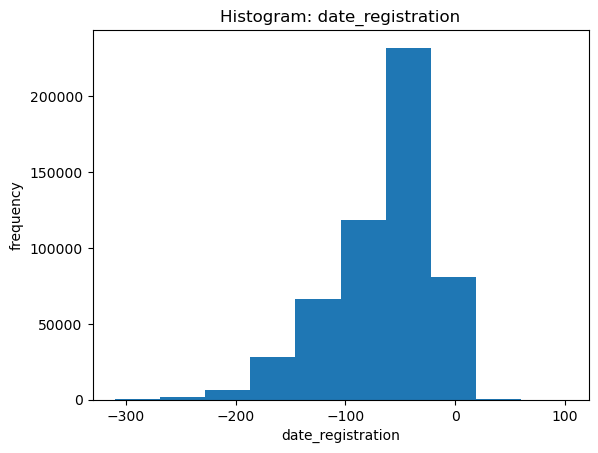

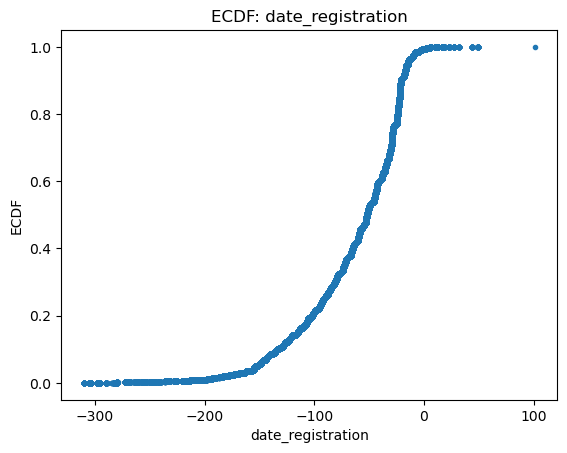

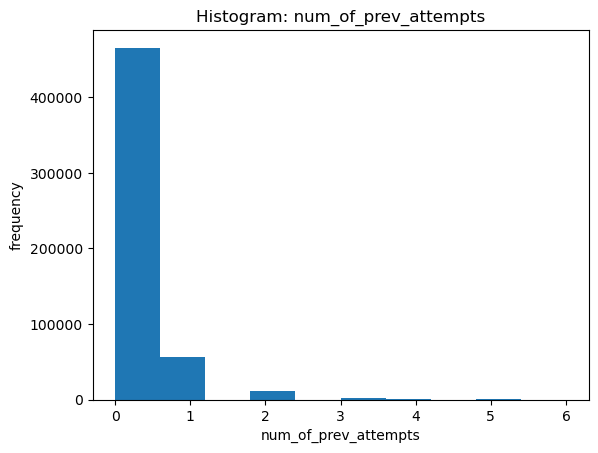

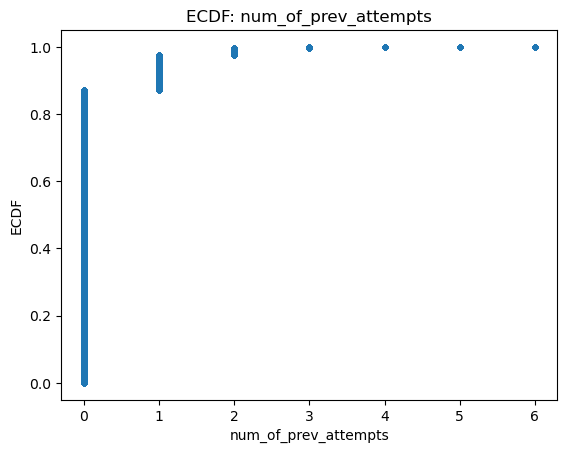

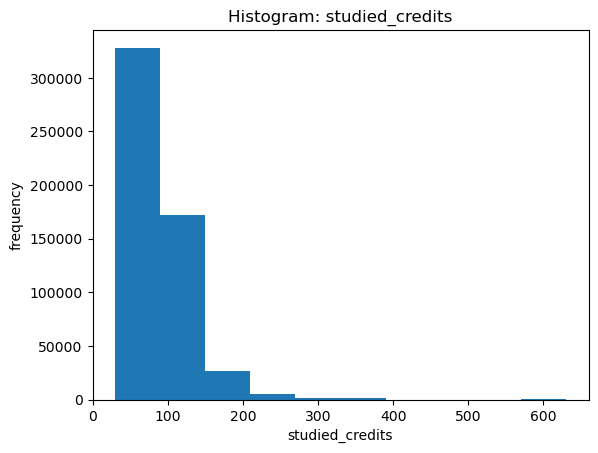

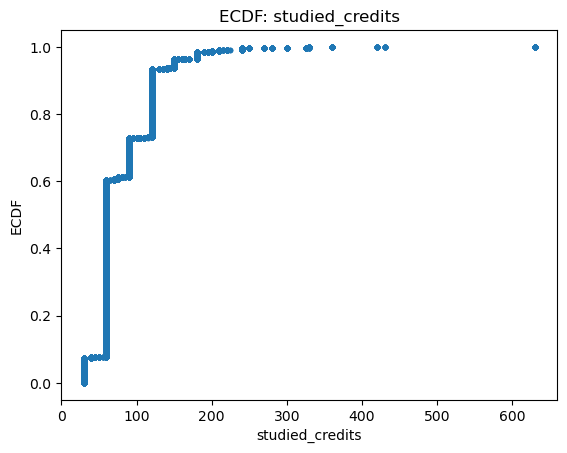

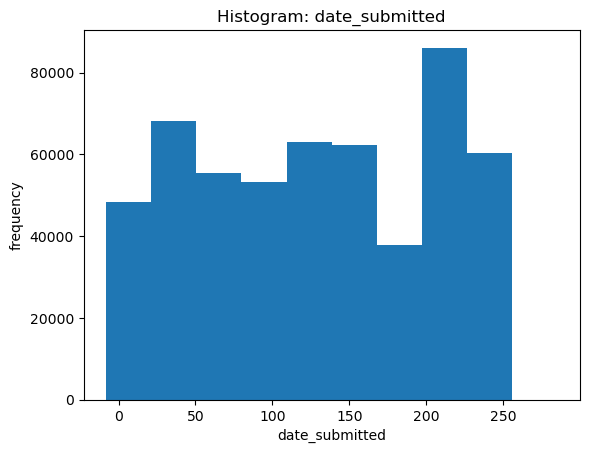

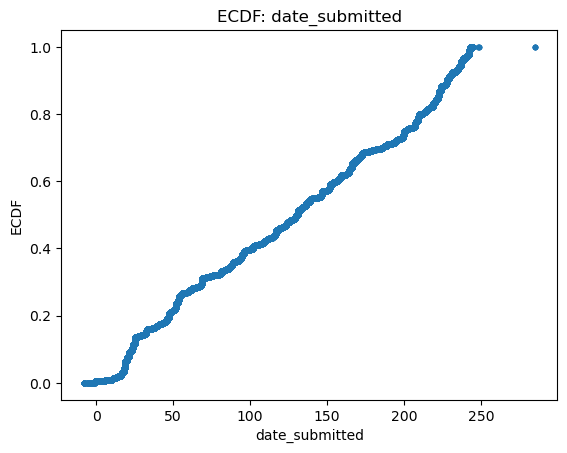

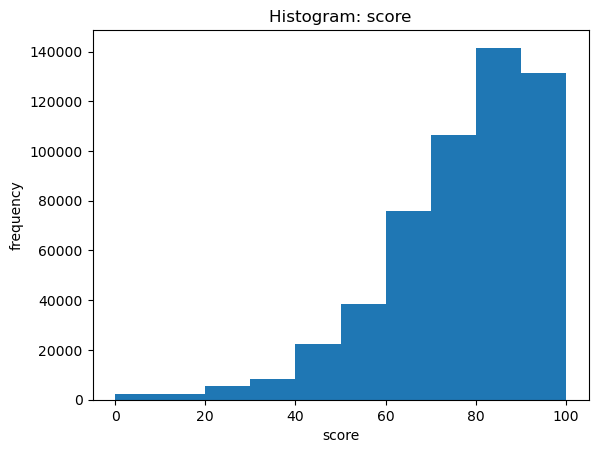

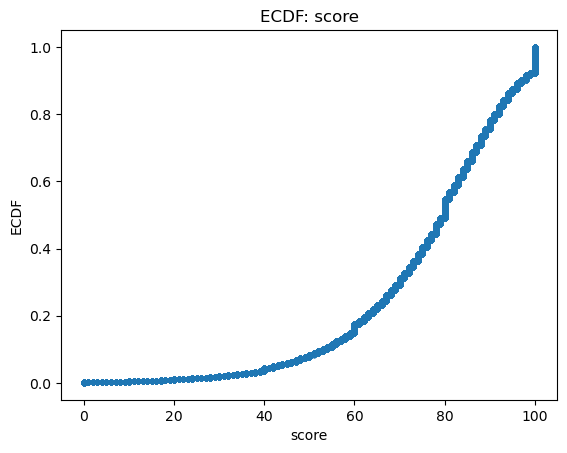

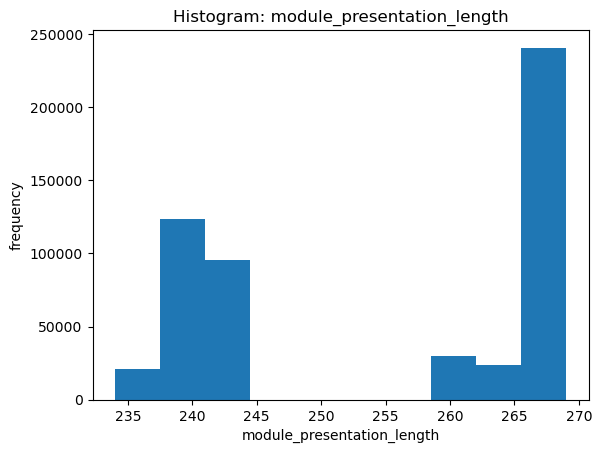

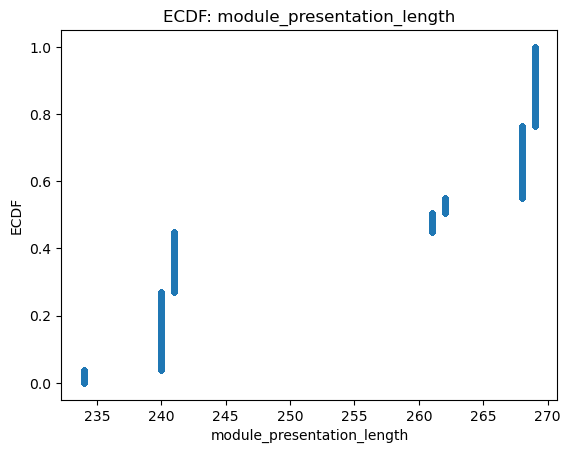

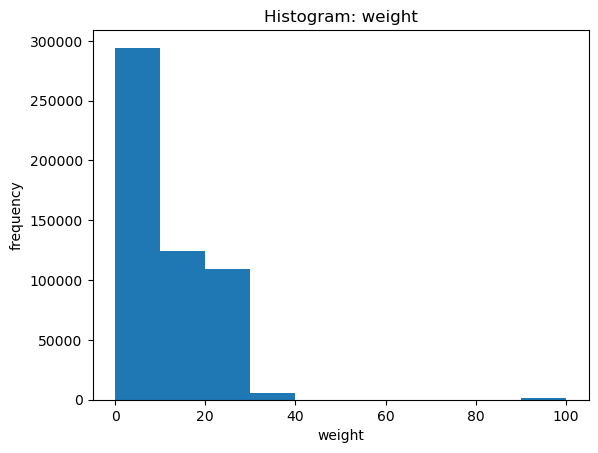

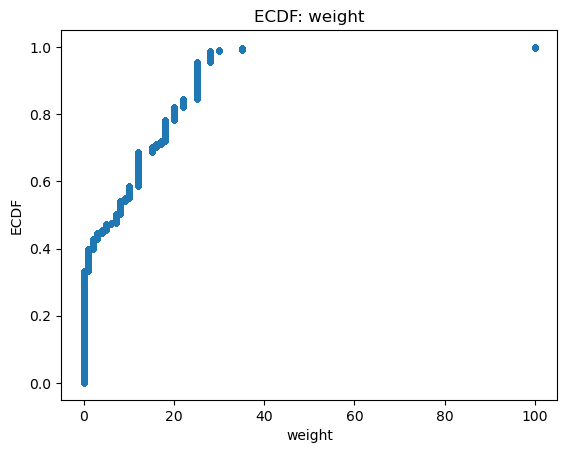

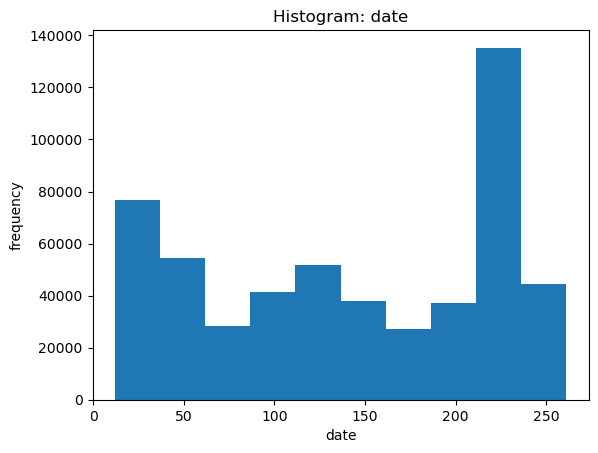

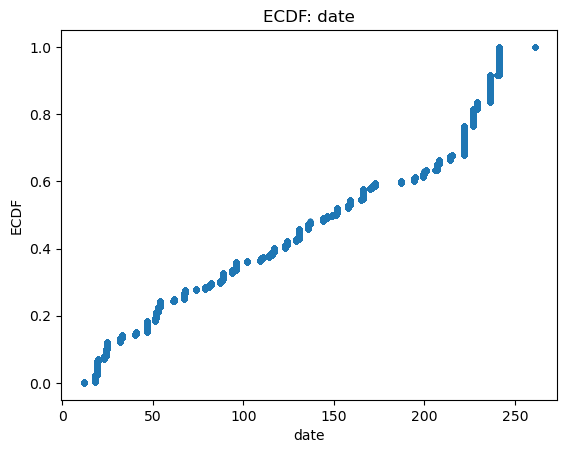

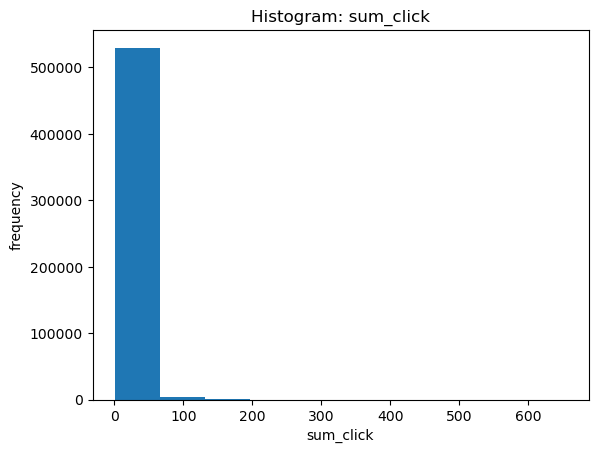

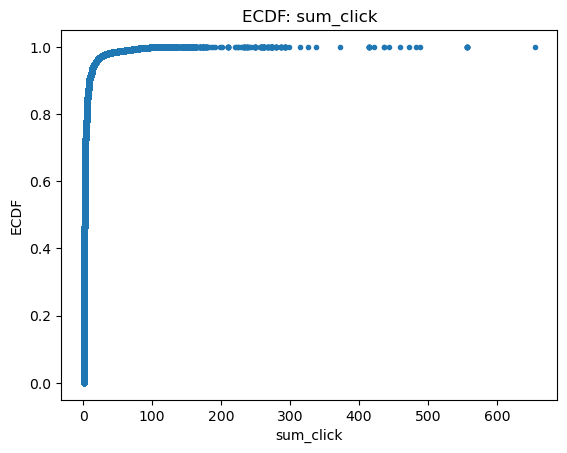

In [18]:
for c in quant_df.columns:
    plt.hist(var_df[c])
    plt.xlabel(f'{c}')
    plt.ylabel('frequency')
    plt.title(f'Histogram: {c}')
    plt.show()
    
    x_c, y_c = ecdf(var_df[c])
    plt.plot(x_c, y_c, marker = '.', linestyle = 'none')
    plt.xlabel(f'{c}')
    plt.ylabel('ECDF')
    plt.title(f'ECDF: {c}')
    plt.show()

In [ ]:
for c in cat_df.columns:
    sns.catplot()